In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pickle as pkl
import scipy

from inversion_tools_remastered import *

# Regularised inversion code

Functions are defined in `inversion_tools`. We first define a few parameters, such as the species of interest, and the spectral ranges. We then load up the data, and subset things spectrally.


In [2]:
# Species and spectral bounds (in cm^{-1}) as a dictionary.
bounds = {
    "CO2": (6250, 6600),
    "CH4": [9100, 9700],
    "H2O": [5500, 5900],
    "CO": [2500, 4000],
}
selected_spectra = list(bounds.keys())

(spectra_obs, absorption_spectra, species_names, wv_obs) = read_data(
    selected_spectra,
    "spectra/test_series/", # Location of the series we want to invert.
    "spectra/templates/" # Location of the individual species "template" absorption
)

100%|██████████| 4/4 [00:00<00:00, 43.93it/s]


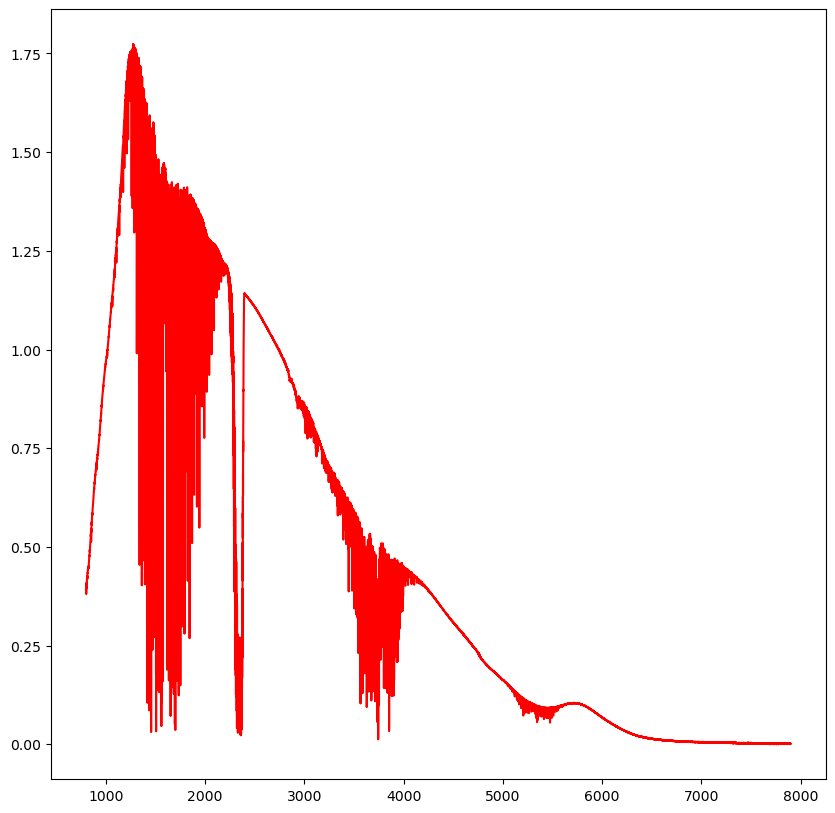

In [17]:
plt.figure(figsize=(10,10))
plt.plot(wv_obs, spectra_obs[15], color = 'red')
plt.savefig('h.pdf')

In [3]:
from pathlib import Path
from os import listdir
from os.path import isfile, join

Freq_obs = np.array(wv_obs)
folder = Path("Calibration/")
files = {f.name:f for f in sorted(folder.rglob("**/*_1ppm_*"))
        if int(f.name.split("_")[3].split(" ")[-1]) > 800}

storage_mtx = np.zeros((31, len(Freq_obs)))
labels =  []
bounds_clip = {}
tmp = np.zeros_like(Freq_obs)
prev_name = ""
output = []
for i, (sp, fname) in enumerate(files.items()):
    labels.append(sp.rstrip(".prn").split("_")[3])
    this_name = sp.rstrip(".prn").split("_")[3]
    wv, abso = np.loadtxt(fname, unpack=True)
    iloc = np.argmin(np.abs(wv.min() - Freq_obs))
    jloc = np.argmin(np.abs(wv.max() - Freq_obs))
    if i != 0 and this_name.split(" ")[0] != prev_name:
        output.append(tmp)
        tmp = np.zeros_like(Freq_obs)
    elif i!=0:
        labels.pop(len(labels)-1)
    prev_name = this_name.split(" ")[0] 
    tmp[iloc:(jloc+1)] = abso

storage_mtx = np.array(output)

In [4]:
labels_new = [''.join(x.split(' ')[0:-2]) for x in labels]

In [5]:
Compounds = ['H2O']

from EmissionsFitting import *

filename_CO2 = "Ref/" + '006_CO2_04_448K_ref296s.prn'
wave_ref = getAbsorption(filename_CO2)[0]
# For the sake of argument, References = A^T.
References = getAbsorptionFeatures(Compounds)

tmp = np.zeros_like(Freq_obs)



In [63]:
f = scipy.interpolate.interp1d(wave_ref, References[0])
ref_seg_adjusted = np.array([f(v) for v in wv_obs if 840<v<3075])
wave_seg_adjusted = np.array([v for v in wv_obs if 840<v<3075])
iloc = np.argmin(np.abs(wave_seg_adjusted.min() - Freq_obs))
jloc = np.argmin(np.abs(wave_seg_adjusted.max() - Freq_obs))
print(iloc,jloc)
tmp[iloc:(jloc+1)] = ref_seg_adjusted
output.append(tmp)

166 9436


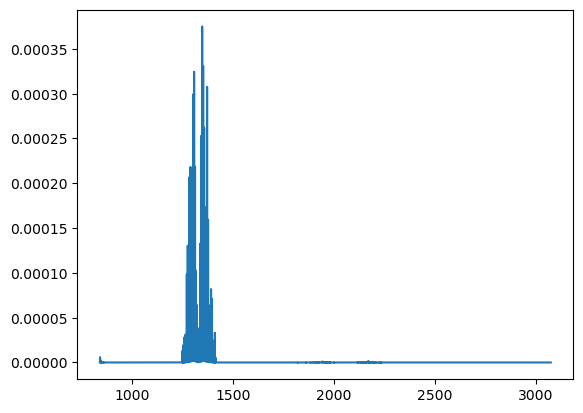

In [64]:
plt.plot(wave_seg_adjusted, ref_seg_adjusted)

In [65]:
storage_mtx = np.array(output)
labels_new.append('H2O')

In [66]:
S = np.array([s[~np.all(storage_mtx == 0, axis=0)] for s in spectra_obs])
S_l = np.array([np.log(x) for x in S])
W = wv_obs[~np.all(storage_mtx == 0, axis=0)]

C:\Users\luker\AppData\Local\Temp\ipykernel_13468\4110678604.py:2: RuntimeWarning: invalid value encountered in log
  S_l = np.array([np.log(x) for x in S])


C:\Users\luker\AppData\Local\Temp\ipykernel_13468\3410334848.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([int(W[x]) for x in [-500, 0,500,1000,1500,2000,2500,3000,3500, len(W)-1]], fontsize=14)


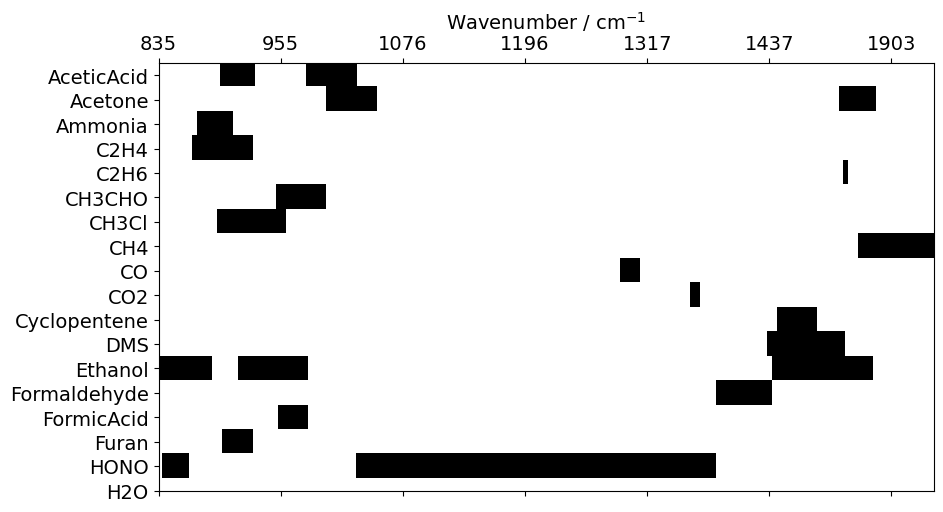

C:\Users\luker\AppData\Local\Temp\ipykernel_13468\3410334848.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([int(W[x]) for x in [-500, 0,500,1000,1500,2000,2500,3000,3500, len(W)-1]], fontsize=14)


Text(0.5, 0, 'Wavenumber / cm$^{-1}$')

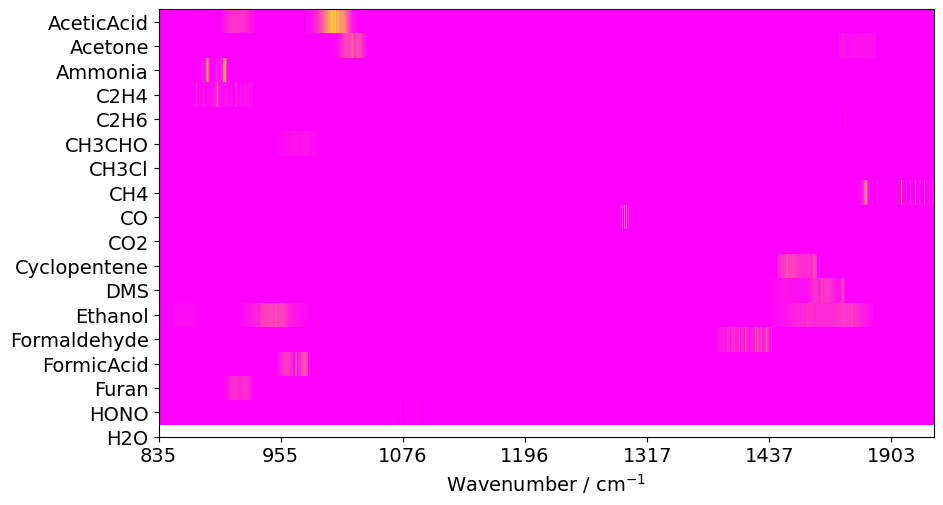

In [70]:
storage_mtx = storage_mtx[:,~np.all(storage_mtx == 0, axis=0)]

fig, ax = plt.subplots(figsize=(10,10))

fig.canvas.draw()

ax.spy(storage_mtx, aspect = 1/0.005)

ax.set_yticks(np.arange(0,18,1))
ax.set_yticklabels(labels_new, fontsize=14)
ax.set_xticklabels([int(W[x]) for x in [-500, 0,500,1000,1500,2000,2500,3000,3500, len(W)-1]], fontsize=14)

ax.set_xlabel('Wavenumber / cm$^{-1}$', fontsize=14)
ax.xaxis.set_label_position('top') 

plt.show()
import scipy.sparse as sprs
fig, ax = plt.subplots(figsize=(10,10))

storage_mtx_SM = sprs.csr_matrix(storage_mtx)

cmap = matplotlib.cm.spring  # Can be any colormap that you want after the cm

d= storage_mtx_SM.todense()
ax.imshow(d,interpolation='none',cmap=cmap, aspect = 1/0.005)

ax.set_yticks(np.arange(0,18,1))
ax.set_yticklabels(labels_new, fontsize=14)
ax.set_xticklabels([int(W[x]) for x in [-500, 0,500,1000,1500,2000,2500,3000,3500, len(W)-1]], fontsize=14)

ax.set_xlabel('Wavenumber / cm$^{-1}$', fontsize=14)

In [16]:
from EmissionsFitting import *

filename_CO2 = "Ref/" + '006_CO2_04_448K_ref296s.prn'
wave_ref = getAbsorption(filename_CO2)[0]

Compounds = ['C2H2', 'ClONO2', 'ClO', 'COF2', 'H2CO', 'H2O2', 'H2O', 'H2S', 'HBr', 'HCl', 'HCN', 'HCOOH', 'HF', 'HI', 'HNO3', 'HO2', 'HOCl', 'N2O', 'N2', 'NH3', 'NO+', 'NO2', 'NO', 'O2', 'O3', 'OCS', 'OH', 'PH3', 'SF6', 'SO2']

# For the sake of argument, References = A^T.
References = getAbsorptionFeatures(Compounds)

del References[13]
del Compounds[13]

In [17]:
bad = []

for i, x in enumerate(References):
    
    tmp = np.zeros_like(Freq_obs)
    
    a = np.array(References[i])
    a[a<(0.15*max(a))] = 0
    
    not_empty = np.where(a!=0)[0]
    
    wave_seg = [wave_ref[v] for v in not_empty]
    ref_seg = [x[v] for v in not_empty]
    
    try:
        f = scipy.interpolate.interp1d(wave_seg, ref_seg)
        ref_seg_adjusted = np.array([f(v) for v in wv_obs if min(wave_seg)<v<max(wave_seg)])
        wave_seg_adjusted = np.array([v for v in wv_obs if min(wave_seg)<v<max(wave_seg)])
        #print(ref_seg_adjusted)
        #print(wave_seg_adjusted)
        iloc = np.argmin(np.abs(wave_seg_adjusted.min() - Freq_obs))
        jloc = np.argmin(np.abs(wave_seg_adjusted.max() - Freq_obs))
        tmp[iloc:(jloc+1)] = ref_seg_adjusted
        output.append(tmp)
    except:
        bad.append(i)
        continue
    
a = 0
for i in bad:
    del References[i+a]
    del Compounds[i+a]
    a += -1
    
for n in Compounds:
    labels_new.append(n)

0
452 625
89 9029
0 9421
1857 9814
5
0 351
0 6556
0 4847
5188 5909
3652 8946
0 2168
0 12875
6434 7967
7682 9427
0 10674
1122 1400
0 12942
5708 6485
0 3888
975 11571
1654 12309
2081 6042
5750 7016
69 1563
6027 6726
3179 3525
4117 4768
2625 3716


In [18]:
print(iloc,jloc)

2625 3716


In [19]:
storage_mtx = np.array(output)

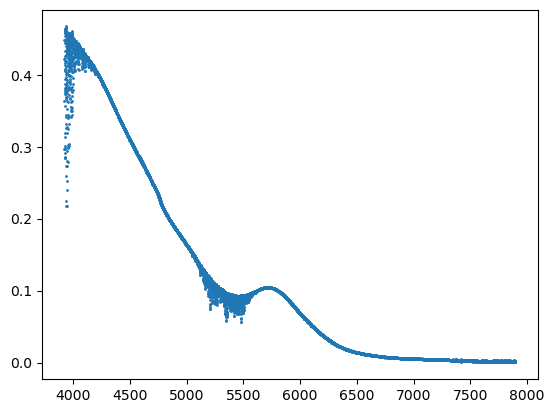

In [20]:
plt.scatter(wv_obs[np.all(storage_mtx == 0, axis=0)], spectra_obs[0][np.all(storage_mtx == 0, axis=0)],s=1)

In [71]:
S = np.array([s[~np.all(storage_mtx == 0, axis=0)] for s in spectra_obs])
S_l = np.array([np.log(x) for x in S])
W = wv_obs[~np.all(storage_mtx == 0, axis=0)]

IndexError: boolean index did not match indexed array along dimension 0; dimension is 29442 but corresponding boolean dimension is 6346

In [72]:
# Note that the remove_background still take bounds_clip as input. This doesn't do anything, I will get round to removing soon.

# Simple background removal and subsetting.
residual_spectra = remove_background(S_l, bounds_clip, W)
# Subsetting of the absorption spectra.

reference_spectra = storage_mtx[:, ~np.all(storage_mtx == 0, axis=0)]

# One by one inversion

This is how you invert individual timesteps (or individual spectra for that matter).

Shown for the two first time steps and timesteps 300 and 350

In [69]:
for tstep in [0, 1, 300, 350]:
    x_sol = np.linalg.lstsq(reference_spectra.T, residual_spectra[tstep, :], rcond=None)
    print(tstep, "=>", x_sol[0])

LinAlgError: SVD did not converge in Linear Least Squares

# Regularised inversion

Now for the regularised inversion. This also returns uncertainty (not complete, as I don't really know what the observational error in the data is). Note that the function returns the variance of the posterior distribution, so we need to take the square root. Here I plot the maximum a posteriori and $\pm \sigma/2$, for good measure.



In [ ]:
gamma_selection = np.loadtxt("gamma_selection.csv")[:-1]
gamma_selection = np.array([0.001, 0.001, 0.001, 0.001,
       0.001, 0.001, 0.001, 0.001,
       0.0001, 0.000005, 0.001, 0.001,
       0.001, 0.001, 0.001, 0.001])

In [ ]:
x_sol,sigma, C = temporally_regularised_inversion(reference_spectra, residual_spectra,
                                                  0.001)

In [ ]:
# Calibration now. Will this affect sigma or C??

with open('CalibrationData.pkl', 'rb') as f:
    cal_temp = pkl.load(f)

prev = ''
cal = {}
for x in cal_temp.keys():
    a = x.split(' ')[0]
    if a != prev:
        cal[x] = cal_temp[x]
    prev = a
    
cal.pop('C2H2')
cal.pop('Toluene ')

nt = residual_spectra.shape[0]

In [ ]:
def ConvertToConc(x_sol, cal, nt):
    
    new_sol = []
    
    for i, x in enumerate(cal.keys()):
        spec_sol = x_sol[i*nt:(i+1)*nt]

        f = scipy.interpolate.interp1d(cal[x]['NormalisationInfo'][0],cal[x]['NormalisationInfo'][1])
        
        for j in range(len(spec_sol)):
            try:
                new_sol.append(f(spec_sol[j]))
            except:
                #print("unphysical")
                new_sol.append(spec_sol[j])
            
    return new_sol

In [ ]:
new_sol = ConvertToConc(x_sol, cal, nt)

In [ ]:
import colorsys

def HSVToRGB(h, s, v): 
    (r, g, b) = colorsys.hsv_to_rgb(h, s, v) 
    return (int(255*r), int(255*g), int(255*b)) 

def getDistinctColors(n): 
    huePartition = 1.0 / (n + 1) 
    return (HSVToRGB(huePartition * value, 1.0, 1.0) for value in range(0, n))

def rgb2hex(rgb):
    return "#{:02x}{:02x}{:02x}".format(rgb[0],rgb[1],rgb[2])

def hilo(a, b, c):
    if c < b: b, c = c, b
    if b < a: a, b = b, a
    if c < b: b, c = c, b
    return a + c

def complement(col):
    r, g, b = col[0], col[1], col[2]
    k = hilo(r, g, b)
    return tuple(k - u for u in (r, g, b))

In [ ]:
fig, axs = plt.subplots(nrows=8, ncols=2, figsize= (20,15),sharex=True)
axs = axs.flatten()
nt = residual_spectra.shape[0]
colours = getDistinctColors(len(labels_new))

for i, spc in enumerate(labels_new):
    try:
        col = next(colours)
        c = rgb2hex(col)
        c_comp = rgb2hex(complement(col))
        axs[i].plot(np.arange(nt), new_sol[i*nt:(i+1)*nt], color = 'red')
        axs[i].fill_between(np.arange(nt), new_sol[i*nt:(i+1)*nt] - 0.5*np.sqrt(sigma[i*nt:(i+1)*nt]),
                            new_sol[i*nt:(i+1)*nt] + 0.5*np.sqrt(sigma[i*nt:(i+1)*nt]),
                            color= "0.8")
        axs[i].set_title(spc, fontsize=20)
        axs[i].tick_params(labelsize=20)
    except:
        continue

fig.text(0.5, -0.001, 'Time Step', ha='center', fontsize=20)
fig.text(-0.003, 0.5, '$\sim$ Concentration (ish)', va='center', rotation='vertical', fontsize=20)

fig.tight_layout()

In [ ]:
x_sol,sigma, C = temporally_regularised_inversion2(reference_spectra, residual_spectra,
                                                  gamma_selection)

In [ ]:
new_sol = ConvertToConc(x_sol, cal, nt)

In [ ]:
fig, axs = plt.subplots(nrows=8, ncols=2, figsize= (20,15),sharex=True)
axs = axs.flatten()
nt = residual_spectra.shape[0]
colours = getDistinctColors(len(labels_new))

for i, spc in enumerate(labels_new):
    try:
        col = next(colours)
        c = rgb2hex(col)
        c_comp = rgb2hex(complement(col))
        axs[i].plot(np.arange(nt), new_sol[i*nt:(i+1)*nt], color = 'red')
        axs[i].fill_between(np.arange(nt), new_sol[i*nt:(i+1)*nt] - 0.5*np.sqrt(sigma[i*nt:(i+1)*nt]),
                            new_sol[i*nt:(i+1)*nt] + 0.5*np.sqrt(sigma[i*nt:(i+1)*nt]),
                            color= "0.8")
        axs[i].set_title(spc, fontsize=20)
        axs[i].tick_params(labelsize=20)
    except:
        continue

fig.text(0.5, -0.001, 'Time Step', ha='center', fontsize=20)
fig.text(-0.003, 0.5, '$\sim$ Concentration (ish)', va='center', rotation='vertical', fontsize=20)

fig.tight_layout()

In [ ]:
fig, axs = plt.subplots(nrows=8, ncols=2, figsize= (20,15),sharex=True)
axs = axs.flatten()
nt = residual_spectra.shape[0]
colours = getDistinctColors(len(labels_new))

for i, spc in enumerate(labels_new):
    try:
        col = next(colours)
        c = rgb2hex(col)
        c_comp = rgb2hex(complement(col))
        arr = [x-new_sol[i*nt:(i+1)*nt][0] for x in new_sol[i*nt:(i+1)*nt]]
        axs[i].plot(np.arange(nt), arr, color = 'red')
        axs[i].fill_between(np.arange(nt), arr - 0.5*np.sqrt(sigma[i*nt:(i+1)*nt]),
                            arr + 0.5*np.sqrt(sigma[i*nt:(i+1)*nt]),
                            color= "0.8")
        axs[i].set_title(spc, fontsize=20)
        axs[i].tick_params(labelsize=20)
    except:
        continue

fig.text(0.5, -0.001, 'Time Step', ha='center', fontsize=20)
fig.text(-0.003, 0.5, '$\sim$ Concentration (ish)', va='center', rotation='vertical', fontsize=20)

fig.tight_layout()

Code below trials the model over N $\gamma$ values and optimises values. These values are loaded earlier for actual use

In [ ]:
def Euclidean_Norm(arr):
    t = 0
    for x in arr:
        t += x**2
    return np.sqrt(t)

Gam_Range = np.logspace(-8, 2.5, num=200)

In [ ]:
# Resid_norm = []
# Soln_norm = []

# for gamma in Gam_Range:
#     x_sol,sigma, C = temporally_regularised_inversion(reference_spectra, residual_spectra, gamma)
    
#     for i in range(len(labels_new)):
#         sol = x_sol[i*nt:(i+1)*nt]
#         resid = np.sqrt(sigma[i*nt:(i+1)*nt])
        
#         if len(Resid_norm) < len(labels_new):
#             Resid_norm.append([])
#             Soln_norm.append([])
        
#         Resid_norm[i].append(Euclidean_Norm(resid))
#         Soln_norm[i].append(Euclidean_Norm(sol))

# np.savetxt("Resid_Norms3.csv", Resid_norm, delimiter=",")
# np.savetxt("Soln_Norms3.csv", Soln_norm, delimiter=",")

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

In [ ]:
viridis = cm.get_cmap('viridis', 12)
norm = mpl.colors.Normalize(vmin=np.log10(Gam_Range).min(), vmax=np.log10(Gam_Range).max())

for i in range(len(Resid_norm)):
    
    fig, ax = plt.subplots()
    
    for x in range(len(Resid_norm[i])):
        ax.scatter(Resid_norm[i][x], Soln_norm[i][x], color = viridis(norm(np.log10(Gam_Range[x]))))
    #plt.xscale('log')
    ax.set_title(labels_new[i], fontsize=15)
    ax.set_xlabel('$\\vert$$\\vert$Residual$\\vert$$\\vert_2$', fontsize=15)
    ax.set_ylabel('$\\vert$$\\vert$Solution$\\vert$$\\vert_2$', fontsize=15)
    ax.tick_params(labelsize=15)
    cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=viridis), ax=ax)
    cbar.ax.set_yticklabels(['10$^{-8}$', '10$^{-6}$', '$10^{-4}$', '$10^{-2}$', '$1$', '$10^{2}$'], fontsize=15)
    cbar.ax.set_ylabel('$\gamma$', rotation=0, fontsize=15)
    plt.show()

In [ ]:
for i in range(len(Resid_norm)):
    
    fig, ax = plt.subplots()
    
    for x in range(len(Resid_norm[i])):
        ax.scatter(Resid_norm[i][x], np.gradient(Soln_norm[i])[x], color = viridis(norm(np.log10(Gam_Range[x]))))
    #plt.xscale('log')
    ax.set_title(labels_new[i], fontsize=15)
    ax.set_xlabel('$\\vert$$\\vert$Residual$\\vert$$\\vert_2$', fontsize=15)
    ax.set_ylabel('Grad($\\vert$$\\vert$Solution$\\vert$$\\vert_2$)', fontsize=15)
    ax.tick_params(labelsize=15)
    cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=viridis), ax=ax)
    cbar.ax.set_yticklabels(['10$^{-8}$', '10$^{-6}$', '$10^{-4}$', '$10^{-2}$', '$1$', '$10^{2}$'], fontsize=15)
    cbar.ax.set_ylabel('$\gamma$', rotation = 0, fontsize=15)
    plt.show()

In [ ]:
gamma_selection = []

for x in Soln_norm:
    index = np.where(abs(np.gradient(x)) == max(abs(np.gradient(x))))
    gamma_selection.append(Gam_Range[index][0])
    

Below will be loading up results from OPUS GA for comparison

In [ ]:
import pandas as pd
df = pd.read_csv('spectra/OPUS_results.txt', sep='\t')

In [ ]:
df.keys()

In [ ]:
plt.plot(df['CO2'])
i = 9

array = new_sol[i*nt:(i+1)*nt]
ind = np.where(array==max(array))[0][0]
ind2 = np.where(df['CO2']==max(df['CO2']))[0][0]
diff = ind - ind2

plt.plot([x - np.arange(nt)[diff:][0] for x in np.arange(nt)[diff:]], array[diff:], color = 'red')
plt.fill_between([x - np.arange(nt)[diff:][0] for x in np.arange(nt)[diff:]], (array - 0.5*np.sqrt(sigma[i*nt:(i+1)*nt]))[diff:],
                    (new_sol[i*nt:(i+1)*nt] + 0.5*np.sqrt(sigma[i*nt:(i+1)*nt]))[diff:], color= "0.8")

In [ ]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Time Step')
ax1.set_ylabel('Weight from our model', color=color)
ax1.plot([x - np.arange(nt)[diff:][0] for x in np.arange(nt)[diff:]], [x - array[diff:][0] for x in array[diff:]], color = 'red')
ax1.fill_between([x - np.arange(nt)[diff:][0] for x in np.arange(nt)[diff:]], [x - array[diff:][0] for x in(array - 0.5*np.sqrt(sigma[i*nt:(i+1)*nt]))[diff:]],
                    [x - array[diff:][0] for x in (new_sol[i*nt:(i+1)*nt] + 0.5*np.sqrt(sigma[i*nt:(i+1)*nt]))[diff:]], color= "0.8")
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Concentration from OPUS GA (substracting minima)', color=color)  # we already handled the x-label with ax1
ax2.plot([x - df['CO2'][0] for x in df['CO2']], color = color)
ax2.tick_params(axis='y', labelcolor=color)

ax2.set_ylim(-100,1500)
ax1.set_ylim(-100,2000)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [ ]:
fig, ax1 = plt.subplots()
i = 9
array = new_sol[i*nt:(i+1)*nt]
ind = np.where(array==max(array))[0][0]
ind2 = np.where(df['CO2']==max(df['CO2']))[0][0]
diff = ind - ind2


ax1.plot([x - np.arange(nt)[diff:][0] for x in np.arange(nt)[diff:]], [x - array[diff:][0] for x in array[diff:]], color = 'red')
ax1.fill_between([x - np.arange(nt)[diff:][0] for x in np.arange(nt)[diff:]], [x - array[diff:][0] for x in(array - 0.5*np.sqrt(sigma[i*nt:(i+1)*nt]))[diff:]],
                    [x - array[diff:][0] for x in (new_sol[i*nt:(i+1)*nt] + 0.5*np.sqrt(sigma[i*nt:(i+1)*nt]))[diff:]], color= "0.8")
ax1.tick_params(axis='y')

ax1.set_ylabel('Concentration')  # we already handled the x-label with ax1
ax1.plot([x - df['CO2'][0] for x in df['CO2']], color = color)
ax1.set_title('CO2')

In [ ]:
i = 8

array = new_sol[i*nt:(i+1)*nt]
ind = np.where(array==max(array))[0][0]
ind2 = np.where(df['CO']==max(df['CO']))[0][0]
diff = ind - ind2


fig, ax1 = plt.subplots()


ax1.plot([x - np.arange(nt)[diff:][0] for x in np.arange(nt)[diff:]], [x - array[diff:][0] for x in array[diff:]], color = 'red')
ax1.fill_between([x - np.arange(nt)[diff:][0] for x in np.arange(nt)[diff:]], [x - array[diff:][0] for x in(array - 0.5*np.sqrt(sigma[i*nt:(i+1)*nt]))[diff:]],
                    [x - array[diff:][0] for x in (new_sol[i*nt:(i+1)*nt] + 0.5*np.sqrt(sigma[i*nt:(i+1)*nt]))[diff:]], color= "0.8")
ax1.tick_params(axis='y')

ax1.set_ylabel('Concentration')  # we already handled the x-label with ax1
ax1.plot([x - df['CO'][0] for x in df['CO']], color = color)
ax1.set_title('CO')

In [ ]:
i = 3

array = new_sol[i*nt:(i+1)*nt]
ind = np.where(array==max(array))[0][0]
ind2 = np.where(df['C2H4']==max(df['C2H4']))[0][0]
diff = ind - ind2


fig, ax1 = plt.subplots()


ax1.plot([x - np.arange(nt)[diff:][0] for x in np.arange(nt)[diff:]], [x - array[diff:][0] for x in array[diff:]], color = 'red', label='Model')
ax1.fill_between([x - np.arange(nt)[diff:][0] for x in np.arange(nt)[diff:]], [x - array[diff:][0] for x in(array - 0.5*np.sqrt(sigma[i*nt:(i+1)*nt]))[diff:]],
                    [x - array[diff:][0] for x in (new_sol[i*nt:(i+1)*nt] + 0.5*np.sqrt(sigma[i*nt:(i+1)*nt]))[diff:]], color= "0.8")
ax1.tick_params(axis='y')

ax1.set_ylabel('Concentration')  # we already handled the x-label with ax1
ax1.set_title('C2H4')
ax1.plot([x - df['C2H4'][0] for x in df['C2H4']], color = color, label= 'OPUS')

plt.legend()

In [ ]:
df.keys()

In [ ]:
labels_new

In [ ]:
i = 3

array = new_sol[i*nt:(i+1)*nt]
plt.plot(array)